Load raw business dataset for Yolo and Sacramento Counties.

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Read businesses in Yolo and Sac County into dataframe
yolosac = pd.read_csv('../processed_data/yolosac.csv')
# Convert category names to lowercase for processing
yolosac['category'] = yolosac['category'].apply(eval).map(lambda x : [cat.lower() for cat in x])


Look at the first 20 categories:

In [31]:
yolosac.category.head(20)

0                                   [massage therapist]
1                                   [massage therapist]
2                                       [door supplier]
3                                              [church]
4                                              [church]
5                                   [employment agency]
6     [billiards supply store, dart supply store, fu...
7                                [motor vehicle dealer]
8     [towing service, auto wrecker, automobile stor...
9                                            [car wash]
10    [garbage collection service, debris removal se...
11                                        [barber shop]
12                          [tile store, antique store]
13                                  [massage therapist]
14                                  [massage therapist]
15                     [massage spa, massage therapist]
16    [computer consultant, computer repair service,...
17                                     [fitness 

- In Google Maps, business owners can tag their business with multiple categories.
- We only care about restaurants, defined as businesses that sell prepared food or drinks.

One hot encode categories for each business for further analysis of which categories tend to co-occur with "restaurant", "cafe", or "bar".

In [32]:
# Credit: https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
def bool_df(item_lists, unique_items):
  bool_dict = {}
  # Iterate over all tags
  for i, item in enumerate(unique_items):
    # Apply Boolean mask
    bool_dict[item] = item_lists.apply(lambda x: item in x)
  
  # Return as dataframe
  return pd.DataFrame(bool_dict)

# List of unique business categories with frequency
unique_cat_freq = pd.DataFrame(yolosac['category'].explode().value_counts())

unique_cat_freq.reset_index(level=0, inplace=True)
unique_cat_freq.rename(columns={'index' : 'category'}, inplace=True)
# Generate boolean matrix where each category is a column (one hot encoding)
categories_bool = bool_df(item_lists=yolosac['category'], unique_items=unique_cat_freq['category'])
categories_bool

,restaurant,fast food restaurant,auto repair shop,park,mexican restaurant,beauty salon,takeout restaurant,coffee shop,grocery store,breakfast restaurant,...,cosmetics industry,airbrushing service,leasing service,optical wholesaler,drilling contractor,chinese medicine clinic,religious school,athletic park,pulmonologist,wildlife park
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17933,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17934,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17935,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17936,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Text(0, 0.5, 'Frequency')

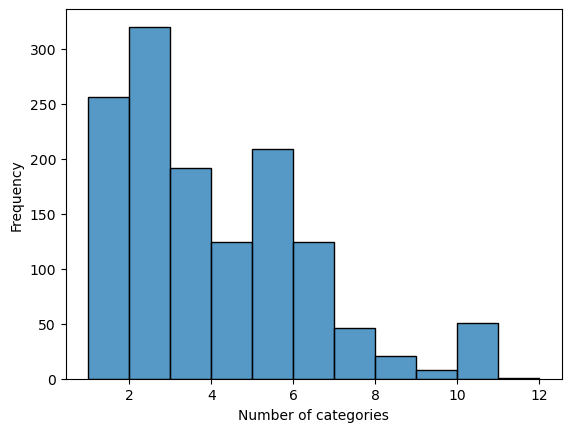

In [33]:
temp = yolosac.loc[categories_bool['restaurant'], 'category'].map(lambda x : len(x))
sns.histplot(temp, binwidth=1)
plt.xlabel('Number of categories')
plt.ylabel('Frequency')

"Restaurants" can have between 0 and 10 additional categories. Most have 1 additional category.

Download GloVE word vector model. We will use this to perform cosine similarity search on the categories to find "restaurants".

In [34]:
import gensim.downloader as api
# Credit: https://nlp.stanford.edu/projects/glove/
key_vec = api.load('glove-wiki-gigaword-100')
key_vec.most_similar('restaurant')

[('cafe', 0.8286571502685547),
 ('restaurants', 0.8099790215492249),
 ('hotel', 0.7762866020202637),
 ('dining', 0.7583158016204834),
 ('shop', 0.7480155825614929),
 ('eatery', 0.7348136305809021),
 ('diner', 0.7175965905189514),
 ('bakery', 0.714818000793457),
 ('chef', 0.699083685874939),
 ('pub', 0.6867989301681519)]

In [35]:
# Use cosine similarity to find the 30 most similar words to restaurant in GloVE vector space
sim_to_restaurant_df = pd.DataFrame(columns=['word', 'similarity to restaurant'], data=key_vec.most_similar(positive=['restaurant'], topn=30))
sim_to_restaurant_df

,word,similarity to restaurant
0,cafe,0.828657
1,restaurants,0.809979
2,hotel,0.776287
3,dining,0.758316
4,shop,0.748016
5,eatery,0.734814
6,diner,0.717597
7,bakery,0.714818
8,chef,0.699084
9,pub,0.686799


- According to GloVE model, there is a strong relationship between restaurants and other types of businesses like shops, supermarkets, and hotels. To extract businesses that match our definition of a restaurant, we will exclude these words.

Construct a list called `sim_to_restaurant` that represents our restaurant category. GloVE will take the average of vectors of each word to represent the general restaurant category in vector space.

In [36]:
sim_to_restaurant = sim_to_restaurant_df.drop(index=[2,4,11,12,13,16,17,18,23,22,26,28,19])['word'].to_list()
print(sim_to_restaurant)

['cafe', 'restaurants', 'dining', 'eatery', 'diner', 'bakery', 'chef', 'pub', 'bistro', 'pizza', 'bar', 'gourmet', 'tavern', 'diners', 'dinner', 'breakfast', 'cafeteria']


Extract the raw categories from `unique_cat_freq` that are similar to the restaurant category.

In [37]:
# Classify if a phrase is similar to the words in a list
# comp is a list of words related to a category, e.g. restaurant-related
def is_it_similar(phrase, comp ,threshold):
  words = phrase.split(' ')
  for w in words:
    for c in comp:
      try:
        sim_score = key_vec.similarity(w, c)
      except KeyError:
        sim_score = 0
      if sim_score > threshold:
        return True
  return False
restaurant = unique_cat_freq[unique_cat_freq['category'].apply(lambda x : is_it_similar(x, sim_to_restaurant, 0.75))]
# Remove categories that sound like restaurants but aren't, like "brow bar"
restaurant.drop(index=[1383,1435], inplace=True)
restaurant

,category,count
0,restaurant,1352
1,fast food restaurant,649
4,mexican restaurant,429
6,takeout restaurant,411
9,breakfast restaurant,380
...,...,...
2163,raw food restaurant,1
2166,bar restaurant furniture store,1
2172,swiss restaurant,1
2286,indian sizzler restaurant,1


In [38]:
def simplify(lst, cats, key='string'):
  for cat in cats:
    if cat in lst:
        return key
  return lst

Replace category label for restaurant businesses to "restaurant"

In [39]:
yolosac['category'] = yolosac['category'].map( lambda x : simplify(x, restaurant['category'].to_list(), 'restaurant')) # School & College

print(yolosac[yolosac['category'] == 'restaurant'].iloc[:50])
print(yolosac[yolosac['category'] == 'restaurant'].shape)

                                 name                                gmap_id  \
28                        China House  0x809ae410bb4b79db:0x8e53e91c4a62cfcd   
48               Kiki's Chicken Place  0x809ae58e5b6f8889:0x997c522d3d5cf906   
81                         Carl's Jr.  0x80852990182f7d55:0xe7374fc8442789f1   
99                       Carlton Club  0x8084d0e5f234f735:0x782262f8c6962382   
105                 Costco Food Court  0x8084d155d59bbe79:0xea9392e201d6ec6f   
146                       China House  0x809ae410bb4b79db:0x8e53e91c4a62cfcd   
166              Kiki's Chicken Place  0x809ae58e5b6f8889:0x997c522d3d5cf906   
199                        Carl's Jr.  0x80852990182f7d55:0xe7374fc8442789f1   
217                      Carlton Club  0x8084d0e5f234f735:0x782262f8c6962382   
223                 Costco Food Court  0x8084d155d59bbe79:0xea9392e201d6ec6f   
238                          Cinnabon  0x809ade2407727363:0x6cb49bc8ac7e5da0   
243                  True North Pizza  0

Save restaurant businesses to a new CSV. Preserves original indices from `yolosac.csv`.

In [40]:
yolosac_restaurants = yolosac[yolosac['category'] == 'restaurant']
yolosac_restaurants.to_csv('../processed_data/yolosac_restaurants.csv')